In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import seaborn as sns
sns.set()

from scipy.optimize import minimize
from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, \
    median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook

# import warnings
# warnings.filterwarnings("ignore")

In [21]:
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv', parse_dates=['date_time'], dayfirst=True)
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [22]:
df = df.drop(["rain_1h",'snow_1h','clouds_all','weather_main', 'weather_description'], axis = 1)
df.head()

,holiday,temp,date_time,traffic_volume
0,None,288.28,2012-10-02 09:00:00,5545
1,None,289.36,2012-10-02 10:00:00,4516
2,None,289.58,2012-10-02 11:00:00,4767
3,None,290.13,2012-10-02 12:00:00,5026
4,None,291.14,2012-10-02 13:00:00,4918


In [23]:
df.shape

(48204, 4)

In [24]:
#Проверяем по дате, все ли значения уникальные
df.date_time.is_unique

False

In [25]:
#Удаляем повторяющиеся значения
df=df.drop_duplicates (subset=['date_time'])

In [26]:
#Снова проверяем. Все норм
df.date_time.is_unique

True

In [27]:
df.shape

(40575, 4)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40575 entries, 0 to 48203
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   holiday         40575 non-null  object        
 1   temp            40575 non-null  float64       
 2   date_time       40575 non-null  datetime64[ns]
 3   traffic_volume  40575 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.5+ MB


In [29]:
#Делаем столбец date_time индексом
df.set_index(pd.DatetimeIndex(df.date_time), inplace=True)

In [30]:
df = df.drop(["date_time"], axis = 1)

In [31]:
df['holiday'].value_counts()

None                         40522
Columbus Day                     5
Veterans Day                     5
Thanksgiving Day                 5
Christmas Day                    5
New Years Day                    5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Labor Day                        5
Martin Luther King Jr Day        3
Name: holiday, dtype: int64

In [32]:
#Сделаю копию, потому что далее пойдут преобразования посерьезнее.
df_2=df.copy(deep=True)

In [33]:
#Хочу закодировать таким образом, чтобы все праздники - 1, будние дни 0.

holiday = {"holiday":     {"None": 0, "Columbus Day": 1, "Veterans Day": 1, "Thanksgiving Day": 1, "Christmas Day": 1,
                          'New Years Day': 1, 'Washingtons Birthday':1, 'Memorial Day':1, 'Independence Day':1, 
                           'State Fair':1, 'Labor Day':1, 'Martin Luther King Jr Day':1}}
df_2= df_2.replace(holiday)

In [34]:
df_2.head()

,holiday,temp,traffic_volume
date_time,,,
2012-10-02 09:00:00,0,288.28,5545
2012-10-02 10:00:00,0,289.36,4516
2012-10-02 11:00:00,0,289.58,4767
2012-10-02 12:00:00,0,290.13,5026
2012-10-02 13:00:00,0,291.14,4918


In [35]:
df_2['holiday'].value_counts()

0    40522
1       53
Name: holiday, dtype: int64

In [36]:
#C помощью данной функции можем вставить в пропущенные часы интерполированные значения из соседних строк
df_2=df_2.resample('1H').mean().interpolate()

In [37]:
df_2.head(30)

,holiday,temp,traffic_volume
date_time,,,
2012-10-02 09:00:00,0.0,288.280000,5545.000000
2012-10-02 10:00:00,0.0,289.360000,4516.000000
2012-10-02 11:00:00,0.0,289.580000,4767.000000
2012-10-02 12:00:00,0.0,290.130000,5026.000000
2012-10-02 13:00:00,0.0,291.140000,4918.000000
2012-10-02 14:00:00,0.0,291.720000,5181.000000
2012-10-02 15:00:00,0.0,293.170000,5584.000000
2012-10-02 16:00:00,0.0,293.860000,6015.000000
2012-10-02 17:00:00,0.0,294.140000,5791.000000


In [38]:
df_2['holiday'].value_counts()

0.0    52493
1.0       53
0.5        5
Name: holiday, dtype: int64

In [39]:
#Как можно видеть, применение интерполяции также привело к тому что у нас появилось значение 0,5 в holiday, 
#чего быть конечно же не может. Поэтому принудительно присвоим значениям 0,5 нулевые значения.

In [40]:
df_2 = df_2.replace({'holiday':{0.5:0}})

In [41]:
df_2['holiday'].value_counts()

0.0    52498
1.0       53
Name: holiday, dtype: int64

In [42]:
#Попробуем визуализировать временной ряд

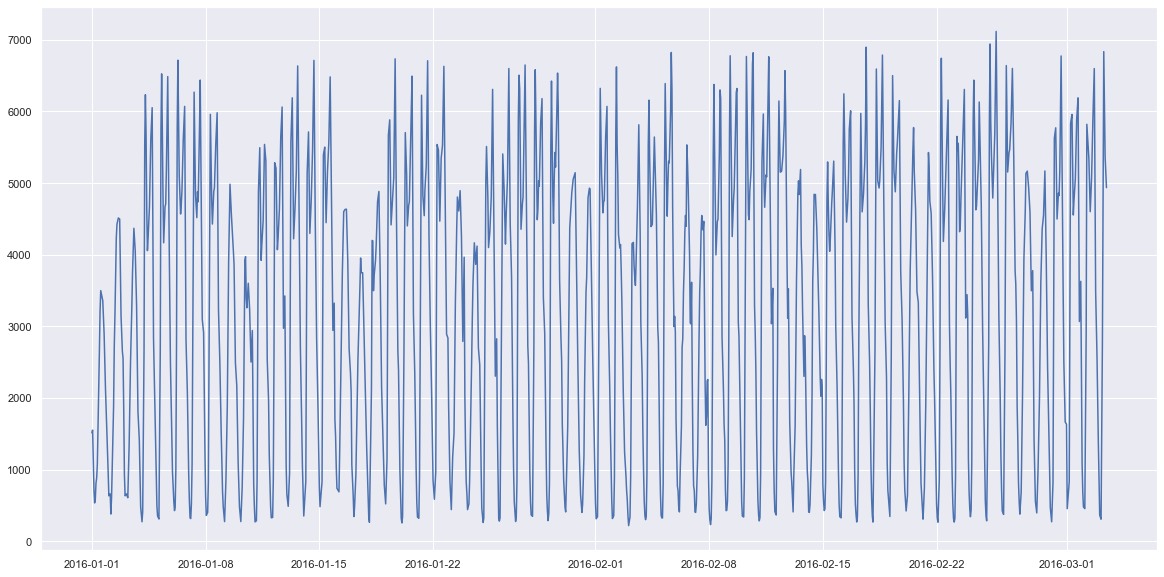

In [68]:
#Ну или более правильно, оставив traffic_volume и date_time. Выведу примерно 3 месяца.
traffic_volume = df_2.traffic_volume
plt.figure(figsize=(20, 10))
plt.plot(traffic_volume[:1500])
plt.show()

In [69]:
#Уберем данные до 2016 года.

In [70]:
df_2 = df_2.loc["2016-01-01 00:00:00":]

In [71]:
df_2.head()

,holiday,temp,traffic_volume
date_time,,,
2016-01-01 00:00:00,1.0,265.940,1513.0
2016-01-01 01:00:00,0.0,266.000,1550.0
2016-01-01 02:00:00,0.0,266.005,1134.5
2016-01-01 03:00:00,0.0,266.010,719.0
2016-01-01 04:00:00,0.0,264.800,533.0


In [72]:
#Отложим последние две недели в датасете для тестирования модели 
df_test=df_2.loc["2018-09-17 00:00:00":]

In [73]:
df_test.head()

,holiday,temp,traffic_volume
date_time,,,
2018-09-17 00:00:00,0.0,296.58,550.0
2018-09-17 01:00:00,0.0,296.19,280.0
2018-09-17 02:00:00,0.0,295.82,260.0
2018-09-17 03:00:00,0.0,295.83,344.0
2018-09-17 04:00:00,0.0,295.68,880.0


In [74]:
#Для обучения соответственно решил взять 2 месяца, просто чтобы графики выглядили репрезентативно.
df_train=df_2.loc["2018-07-16 23:00:00":"2018-09-16 23:00:00"]

In [75]:
df_train.tail()

,holiday,temp,traffic_volume
date_time,,,
2018-09-16 19:00:00,0.0,303.02,3400.0
2018-09-16 20:00:00,0.0,300.78,3092.0
2018-09-16 21:00:00,0.0,298.90,2623.0
2018-09-16 22:00:00,0.0,297.85,1725.0
2018-09-16 23:00:00,0.0,297.44,1088.0


In [76]:
df_train.head()

,holiday,temp,traffic_volume
date_time,,,
2018-07-16 23:00:00,0.0,295.35,1096.0
2018-07-17 00:00:00,0.0,294.58,595.0
2018-07-17 01:00:00,0.0,294.00,407.0
2018-07-17 02:00:00,0.0,292.38,274.0
2018-07-17 03:00:00,0.0,292.15,356.0


In [77]:
df_train.shape

(1489, 3)

In [78]:
df_train_traffic=df_train[['traffic_volume']]

In [81]:
df_train_traffic = df_train_traffic.rename(columns={"traffic_volume": "x"})

In [44]:
# df_train_traffic.reset_index(drop=True, inplace=True)

In [69]:
df_train_traffic.shape

(1489, 1)

In [82]:
df_train_traffic.head()

,x
date_time,
2018-07-16 23:00:00,1096.0
2018-07-17 00:00:00,595.0
2018-07-17 01:00:00,407.0
2018-07-17 02:00:00,274.0
2018-07-17 03:00:00,356.0


In [83]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [84]:
class HoltWinters:
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    :param series:          initial time series
    :param slen:            length of a season
    :param alpha:           Holt-Winters model coefficient
    :param beta:            Holt-Winters model coefficient
    :param gamma:           Holt-Winters model coefficient
    :param n_preds:         predictions horizon
    :param scaling_factor:  sets the width of the confidence interval by Brutlag (usually, values from 2 to 3)
    """
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum_ = 0.0
        for i in range(self.slen):
            sum_ += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum_ / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

def plotHoltWinters(series, model, n_test_points=0, plot_intervals=False, plot_anomalies=False):
    """
    :param series:          Dataset with timeseries
    :type series:            pd.Series
    :param model:           HoltWinters model
    :type model:             HoltWinters
    :param plot_intervals:  Plot confidence intervals
    :type plot_intervals:    bool
    :param plot_anomalies:  Plot anomalies
    :type plot_anomalies:    bool
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(series.values, label = "Actual")
    plt.plot(model.result, label = "Model")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-n_test_points, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

In [85]:
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=12):
    """
    Returns error on CV
    :param params:         Vector of parameters for optimization
    :type params:           (int, int, int)
    :param series:         Dataset with timeseries
    :type series:           pd.Series
    :param loss_function:  Loss function in the same from as losses from sklearn
    :type loss_function:    function
    :param slen:           Season length for Holt-Winters model
    :type slen:             int
    """
    assert type(series)==pd.Series, "series has to be pd.Series"
    
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):
        model = HoltWinters(series=values[train],
                            slen=24*7, 
                            alpha=alpha,
                            beta=beta,
                            gamma=gamma,
                            n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
    
    return np.mean(np.array(errors))

def find_optimal_HW_parameteres(data, slen):
    # initializing model parameters alpha, beta and gamma
    init_params = [0, 0, 0] 
    param_bounds = ((0, 1), (0, 1), (0, 1))

    # Minimizing the loss function 
    opt = minimize(timeseriesCVscore,
                   x0=init_params,
                   args=(data, mean_squared_error, slen),
                   method="TNC",
                   bounds=param_bounds)

    # Take optimal values...
    alpha_final, beta_final, gamma_final = opt.x
    
    #print("Alpha =", alpha_final)
    #print("Beta  =", beta_final)
    #print("Gamma =", gamma_final)
    
    return alpha_final, beta_final, gamma_final

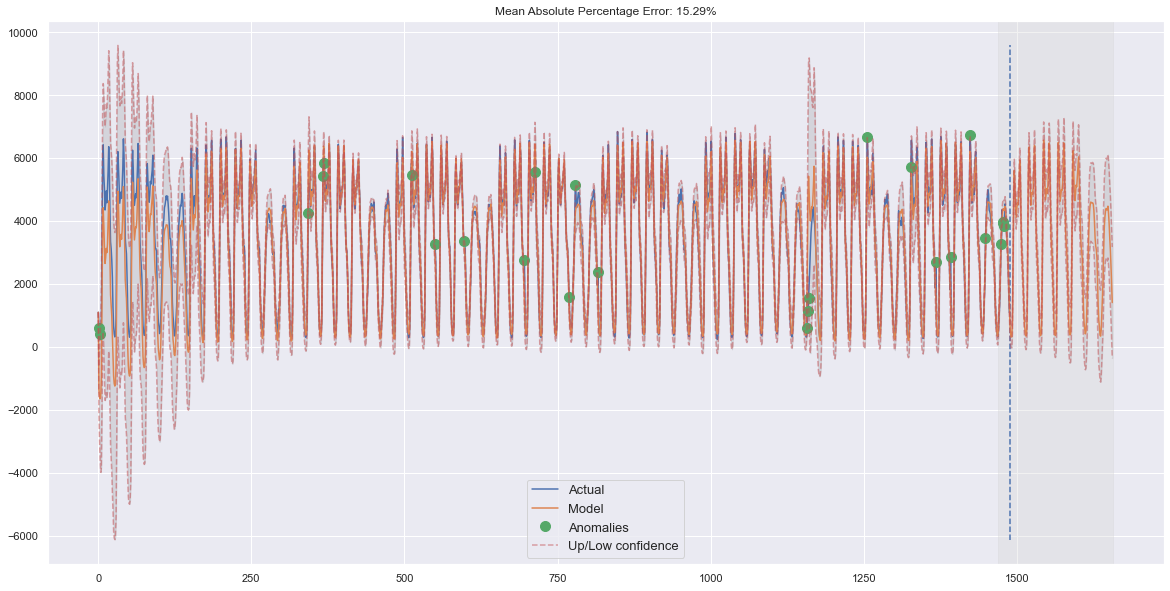

In [86]:
n_test_points = 20
data = df_train_traffic.x[:-n_test_points] # leave some data for testing
SLEN = 24*7

alpha_final, beta_final, gamma_final = find_optimal_HW_parameteres(data, slen=SLEN)

model = HoltWinters(data,
                    slen=SLEN, 
                    alpha=alpha_final, 
                    beta=beta_final, 
                    gamma=gamma_final, 
                    n_preds=n_test_points+SLEN,
                    scaling_factor=3)
model.triple_exponential_smoothing()

plotHoltWinters(df_train_traffic.x, model, n_test_points=n_test_points, plot_intervals=True, plot_anomalies=True)

In [87]:
#Даже вменяемая точность получилась, можно использовать как baseline.

In [88]:
#Можно сделать предсказание на 5 дней вперед

In [93]:
data = df_train_traffic.x
model = HoltWinters(data[:-128], slen = 24*7, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = 128, scaling_factor = 2.56)
model.triple_exponential_smoothing()

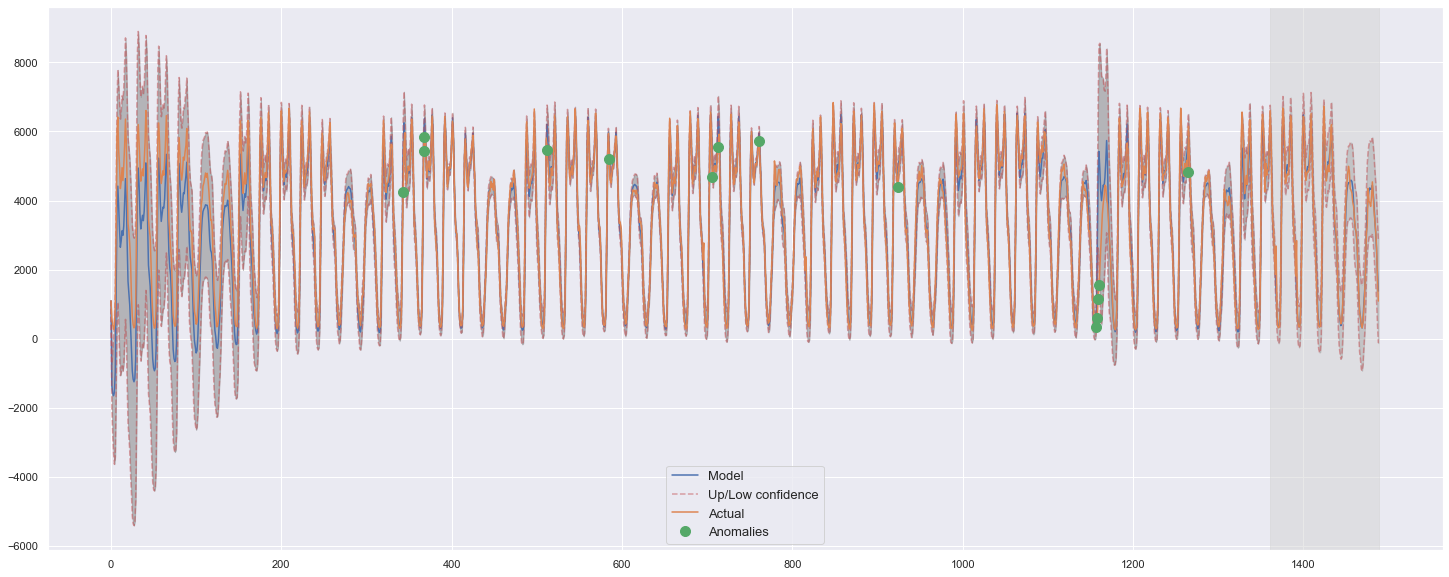

In [94]:
def plotHoltWinters():
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    plt.axvspan(len(data)-128, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

plotHoltWinters()

In [ ]:
#Попробуем модель SARIMA

In [132]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
    Plot time series, its ACF and PACF, calculate Dickey–Fuller test
    :param y:     Timeseries
    :param lags:  How many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method="ols")
        plt.tight_layout()

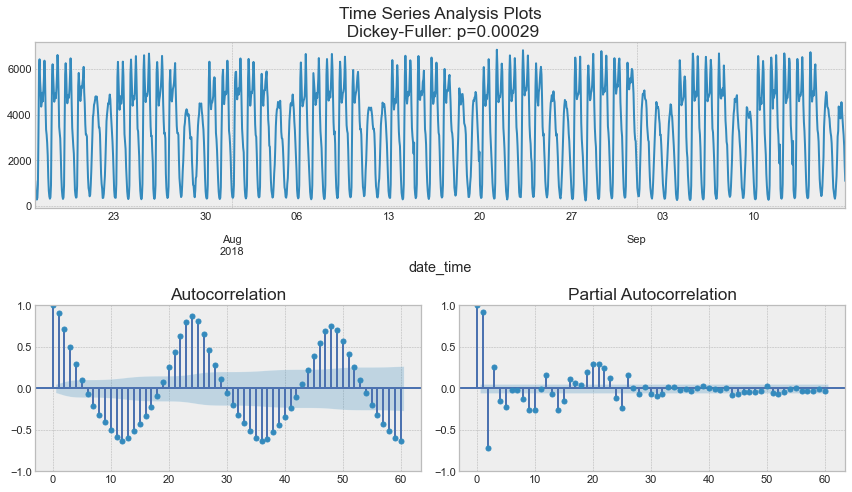

In [133]:
tsplot(df_train_traffic.x, lags=60)

In [ ]:
#Ряд стационарен, тренда нет. Присутсвует четкая сезонная составляющая - каждые 24 часа.

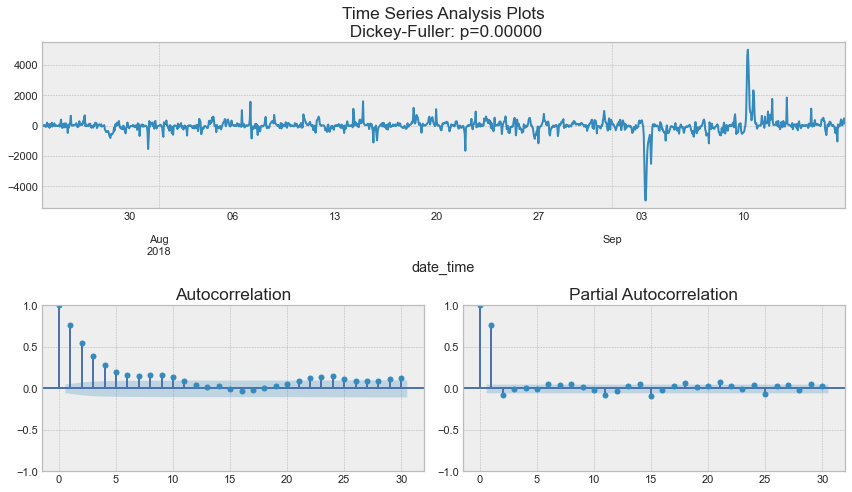

In [141]:
data = df_train_traffic.copy()
data['x_season'] = data.x - data.x.shift(24*7)
tsplot(data.x_season[24*7:], lags=30)

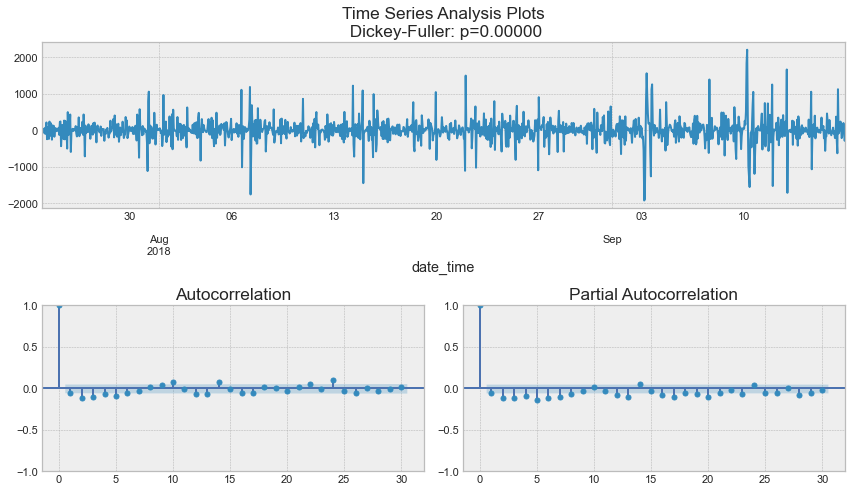

In [142]:
data['x_season_diff'] = data.x_season - data.x_season.shift(1)
tsplot(data.x_season_diff[24*7+1:], lags=30)

In [ ]:
#Так и не понял прикол этих преобразований, так как на вход все равно подается "х" в моем случае, 
#а полученные новые столбцы не учитываются (в модель нельзя подать более 1го столбца, выпадает ошибка).

In [ ]:
#SARIMA без настройки гиперпараметров

In [178]:
def plotSARIMA(series, model, n_steps, s=24, d=1, plot_intervals=True, alpha=0.2):
    """
    Plots model vs predicted values
    :param series:   Dataset with timeseries
    :type series:     pd.DataFrame
    :param model:    Fitted SARIMA model
    :type model:      sm.tsa.statespace.SARIMAX
    :param n_steps:  Number of steps to predict in the future
    :type n_steps:    int
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.get_forecast(steps=n_steps)
    model_predictions = data.arima_model.append(forecast.predicted_mean)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))    
    
    plt.plot(model_predictions, color='r', label="model")
    plt.plot(data.actual, label="actual")
    
    if plot_intervals:
        intervals = forecast.conf_int(alpha=alpha)
        intervals.columns=['lower', 'upper']
        plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(intervals['upper'], "r--", alpha=0.5)
        plt.fill_between(x=intervals.index, y1=intervals['upper'],
                         y2=intervals['lower'], alpha=0.2, color = "grey")
    
    plt.legend()
    plt.grid(True)

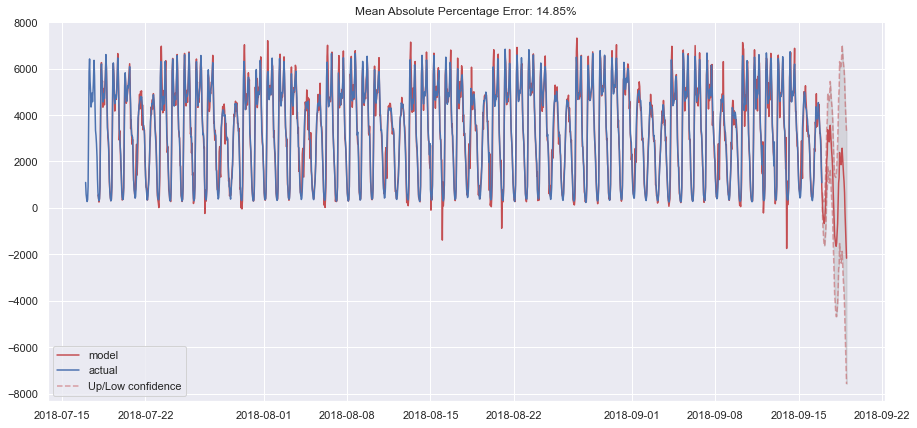

In [186]:
p, d, q = 1, 1, 1
P, D, Q = 0, 1, 0
s = 24

model = sm.tsa.statespace.SARIMAX(df_train_traffic.x,
                                  order=(p, d, q),
                                  seasonal_order=(P, D, Q, s)).fit(disp=-1)

plotSARIMA(df_train_traffic, model, n_steps=50, s=s, d=d, plot_intervals=True, alpha=0.5)

In [73]:
#С дефолтными параметрами получается такая точность. Попробуем подобрать параметры.

In [152]:
def optimizeSARIMA(data, parameters_list, d, D, s):
    """
    Return dataframe with parameters and corresponding AIC
    :param parameters_list:  list with (p, q, P, Q) tuples
    :type parameters_list:    list
    :param d:                integration order in ARIMA model
    :type d:                  int
    :param D:                seasonal integration order
    :type D:                  int
    :param s:                length of season
    :type s:                  int
    """
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model = sm.tsa.statespace.SARIMAX(data,
                order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [153]:
%%time

ps = range(1, 3)
d = 1
qs = range(1, 3)
Ps = range(0, 3)
D = 1
Qs = range(0, 3)
s = 24

# creating list with all the possible combinations of parameters
parameters_list = list(product(ps, qs, Ps, Qs))

result_table = optimizeSARIMA(df_train_traffic.x, parameters_list, d, D, s)

C:\Users\zhuko\AppData\Local\Temp/ipykernel_9756/3506391312.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(parameters_list):


  0%|          | 0/36 [00:00<?, ?it/s]

C:\Users\zhuko\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\zhuko\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\zhuko\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\zhuko\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\zhuko\anaconda3\lib\site-packages\statsmodels\base\model.py:604: C

Wall time: 13min 6s


In [155]:
result_table.head()

,parameters,aic
0,"(2, 1, 2, 2)",21091.073593
1,"(1, 2, 2, 2)",21150.983231
2,"(2, 2, 2, 2)",21161.692064
3,"(2, 2, 2, 1)",21196.019355
4,"(2, 1, 2, 1)",21197.452927


In [159]:
p, q, P, Q = result_table.parameters[0]
best_model = sm.tsa.statespace.SARIMAX(df_train_traffic.x, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

C:\Users\zhuko\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\zhuko\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                                       x   No. Observations:                 1489
Model:             SARIMAX(2, 1, 1)x(2, 1, [1, 2], 24)   Log Likelihood              -10537.537
Date:                                 Sat, 15 Apr 2023   AIC                          21091.074
Time:                                         10:25:42   BIC                          21133.385
Sample:                                     07-16-2018   HQIC                         21106.855
                                          - 09-16-2018                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1907      0.017     69.711      0.000       1.157       1

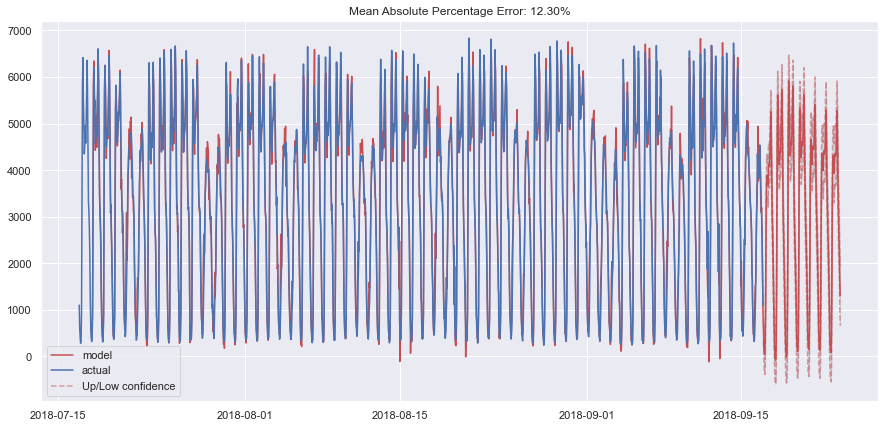

In [478]:
plotSARIMA(df_train_traffic, best_model, n_steps=168, s=s, d=d, plot_intervals=True, alpha=0.5)

In [ ]:
#Решил попробовать рекуррентный прогноз, а в качестве модели линейную регрессию и градиентный бустинг.

In [95]:
def create_lags(df, series_columns, start_lag, end_lag):
    data = df.copy()
    for c in series_columns:
        for i in range(start_lag, end_lag):
            data["lag_{}_{}".format(c, i)] = data[c].shift(i)
    return data


def timeseries_train_test_split(y, X=None, test_size=0.2):
    """
    Performs train-test split with respect to time series structure
    :param X:         x data
    :type X:           pd.DataFrame
    :param y:         y data
    :type y:           pd.Series
    :param test_size: percent of test data from the end of series (0-1)
    :type test_size:   float
    """
    test_index = int(len(y)*(1-test_size))
    
    if X is None:
        y_train = y.iloc[:test_index]
        y_test = y.iloc[test_index:]
        return y_train, y_test
    else:
        X_train = X.iloc[:test_index]
        y_train = y.iloc[:test_index]
        X_test = X.iloc[test_index:]
        y_test = y.iloc[test_index:]
        return X_train, X_test, y_train, y_test

In [96]:
data = create_lags(df=df_train_traffic, series_columns=["x"], start_lag=1, end_lag=200)

y = data.dropna()["x"]
X = data.dropna().drop(["x"], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(y, X, test_size=0.3)

C:\Users\zhuko\AppData\Local\Temp/ipykernel_13236/2495154527.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data["lag_{}_{}".format(c, i)] = data[c].shift(i)


In [97]:
X_train

,lag_x_1,lag_x_2,lag_x_3,lag_x_4,lag_x_5,lag_x_6,lag_x_7,lag_x_8,lag_x_9,lag_x_10,...,lag_x_190,lag_x_191,lag_x_192,lag_x_193,lag_x_194,lag_x_195,lag_x_196,lag_x_197,lag_x_198,lag_x_199
date_time,,,,,,,,,,,,,,,,,,,,,
2018-07-25 06:00:00,3121.0,955.0,372.0,290.0,388.0,664.0,1269.0,2178.0,2727.0,3266.0,...,5455.0,6417.0,5870.0,3171.0,930.0,356.0,274.0,407.0,595.0,1096.0
2018-07-25 07:00:00,5926.0,3121.0,955.0,372.0,290.0,388.0,664.0,1269.0,2178.0,2727.0,...,5030.0,5455.0,6417.0,5870.0,3171.0,930.0,356.0,274.0,407.0,595.0
2018-07-25 08:00:00,6595.0,5926.0,3121.0,955.0,372.0,290.0,388.0,664.0,1269.0,2178.0,...,4346.0,5030.0,5455.0,6417.0,5870.0,3171.0,930.0,356.0,274.0,407.0
2018-07-25 09:00:00,5651.0,6595.0,5926.0,3121.0,955.0,372.0,290.0,388.0,664.0,1269.0,...,4540.0,4346.0,5030.0,5455.0,6417.0,5870.0,3171.0,930.0,356.0,274.0
2018-07-25 10:00:00,4974.0,5651.0,6595.0,5926.0,3121.0,955.0,372.0,290.0,388.0,664.0,...,4952.0,4540.0,4346.0,5030.0,5455.0,6417.0,5870.0,3171.0,930.0,356.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 15:00:00,5705.0,5400.0,5587.0,5359.0,5102.0,5328.0,5687.0,6270.0,5200.0,2754.0,...,5780.0,6586.0,5848.0,5312.0,5051.0,5136.0,5015.0,4837.0,5583.0,6162.0
2018-08-31 16:00:00,5998.0,5705.0,5400.0,5587.0,5359.0,5102.0,5328.0,5687.0,6270.0,5200.0,...,4750.0,5780.0,6586.0,5848.0,5312.0,5051.0,5136.0,5015.0,4837.0,5583.0
2018-08-31 17:00:00,5925.0,5998.0,5705.0,5400.0,5587.0,5359.0,5102.0,5328.0,5687.0,6270.0,...,3519.0,4750.0,5780.0,6586.0,5848.0,5312.0,5051.0,5136.0,5015.0,4837.0


In [98]:
def recursive_predict(model, df_forecast):
    horizon = len(df_forecast)
    
    df_pred = df_forecast.copy()
    df_pred.iloc[1:] = np.nan
    
    forecast = []
    
    for i in range(horizon):
        next_x = model.predict(df_pred.iloc[[i], :])[0]
        if i < horizon-1:
            df_pred.iloc[i+1,0] = next_x
            df_pred.iloc[[i+1],1:] = df_pred.iloc[i,:-1].values
        forecast.append(next_x)
    
    return np.array(forecast)


def plotRecursivePrediction(model, X_test, y_test):
    prediction = recursive_predict(model, X_test)
    
    plt.figure(figsize=(15, 7))
    
    error = mean_absolute_percentage_error(prediction, y_test.values)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)

In [99]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

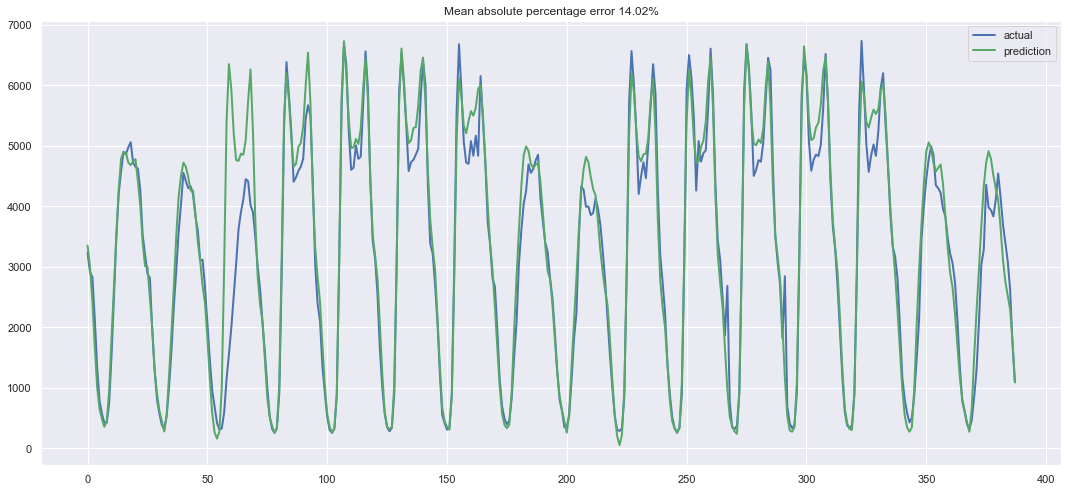

In [100]:
plotRecursivePrediction(lr, X_test, y_test)

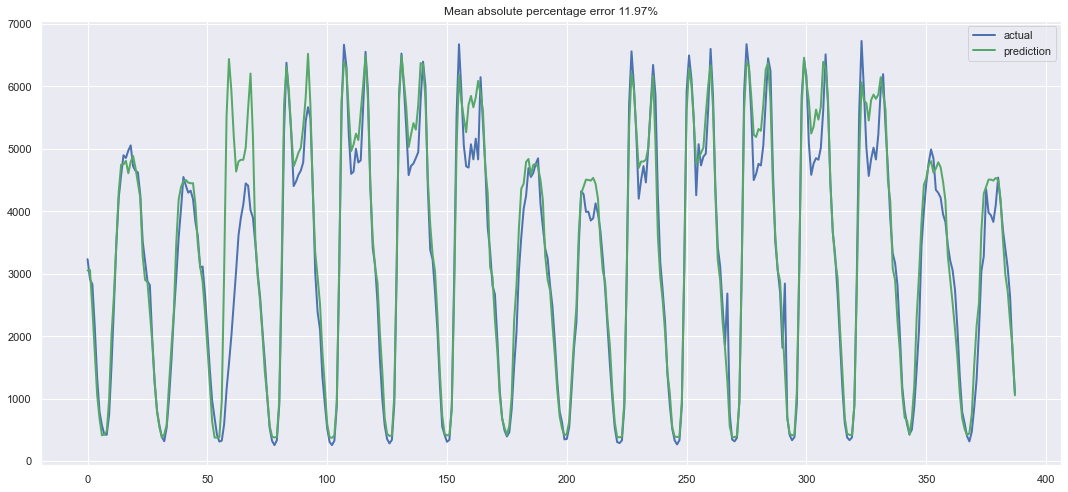

In [101]:
# градиентный бустинг
gb = GradientBoostingRegressor(n_estimators=100)
gb.fit(X_train, y_train)

plotRecursivePrediction(gb, X_test, y_test)

In [102]:
#Попробуем со всеми фичами

In [103]:
# df_train = df_train.drop(["temp"], axis = 1)

In [104]:
df_train= df_train.rename(columns={"traffic_volume": "x"})
df_train_traffic

,x
date_time,
2018-07-16 23:00:00,1096.0
2018-07-17 00:00:00,595.0
2018-07-17 01:00:00,407.0
2018-07-17 02:00:00,274.0
2018-07-17 03:00:00,356.0
...,...
2018-09-16 19:00:00,3400.0
2018-09-16 20:00:00,3092.0
2018-09-16 21:00:00,2623.0


In [105]:
def create_time_features(data):
    data["hour"] = data.index.hour.values
    data['hour_cos'] = np.cos(2 * np.pi * data["hour"].values / 23)
    data['hour_sin'] = np.sin(2 * np.pi * data["hour"].values / 23)
    data["is_weekend"] = data.index.weekday.isin([5,6]).astype(int)
    return data


class MeanEncoder:
    def __init__(self, y_col, cat_feat):
        self.y_col = y_col
        self.cat_feat = cat_feat
        self.mean_codes = None
    
    def fit(self, data):
        cols = [self.y_col] + self.cat_feat
        self.mean_codes = data[cols].groupby(self.cat_feat).mean().to_dict()[self.y_col]
    
    def get_period_means(self, data):
        return data[self.cat_feat].apply(self._encode_with_mean, axis=1)
    
    def _encode_with_mean(self, row):
        key = tuple(row)
        val = self.mean_codes[key]
        return val


class LagEncoder:
    def __init__(self, start_lag, end_lag):
        self.start_lag = start_lag
        self.end_lag = end_lag
        self.lag_columns = []
        for i in range(self.start_lag, self.end_lag+1):
            col_name = "lag_{}".format(i)
            self.lag_columns.append(col_name)
    
    def get_lags(self, series):
        df_lags = pd.DataFrame(index=series.index)
        for i in range(self.start_lag, self.end_lag+1):
            col_name = self.lag_columns[i-1]
            df_lags[col_name] = series.shift(i)
        return df_lags

In [106]:
series_train, series_test = timeseries_train_test_split(df_train_traffic, test_size=0.3)

mean_encoder = MeanEncoder(y_col="x", cat_feat=["hour", "is_weekend"])
scaler = StandardScaler()
lag_encoder = LagEncoder(start_lag=1, end_lag=30)

In [107]:
# функция для запуска процесса формирования лагов
def prepare_data_from_1D_series(series):
    df_series = pd.DataFrame(series)
    df_series.index = pd.to_datetime(df_series.index)

    df_lags = lag_encoder.get_lags(series)
    data = pd.concat([df_series, df_lags], axis=1)
    
    data = create_time_features(data)

    mean_encoder.fit(data)
    data["mean_code"] = mean_encoder.get_period_means(data)

    data.dropna(inplace=True)
    
    data.loc[:,:] = scaler.fit_transform(data)
    
    feat_cols = data.columns.tolist()
    feat_cols.remove("x")
    
    Y = data["x"]
    X = data[feat_cols]
    
    forecast_start_X = data.loc[data.index[-1],["x"] + lag_encoder.lag_columns[:-1]]
    forecast_start_X.index = lag_encoder.lag_columns
    
    return X, Y, feat_cols, forecast_start_X

In [108]:
# построить датафрейм для тестовых данных
def create_forecast_timestamp(series, forecast_horizon):
    t2 = pd.to_datetime(series.index[-1])
    t1 = pd.to_datetime(series.index[-2])
    delta = t2 - t1
    t_index = [t2 + delta]
    for _ in range(forecast_horizon-1):
        t_index.append(t_index[-1] + delta)
    return t_index


def build_forecast_df(series, feat_cols, forecast_start_X, forecast_horizon):
    t_index = create_forecast_timestamp(series, forecast_horizon=forecast_horizon)
    forecast_df = pd.DataFrame(columns=["x"]+feat_cols, index=t_index)

    forecast_df = create_time_features(forecast_df)
    forecast_df["mean_code"] = mean_encoder.get_period_means(forecast_df)
    
    forecast_df.iloc[:,:] = scaler.transform(forecast_df)

    forecast_df.loc[t_index[0], lag_encoder.lag_columns] = forecast_start_X.values
    return forecast_df

In [109]:
def recursive_predict(model, df_forecast):
    horizon = len(df_forecast)
    df_pred = df_forecast.copy()
    forecast = []
    lagcols = lag_encoder.lag_columns
    t = df_forecast.index
    
    feat_cols = df_forecast.columns.tolist()
    feat_cols.remove("x")
    
    for i in range(horizon):
        timestamp = t[i]
        next_x = model.predict(df_pred.loc[[timestamp], feat_cols])[0]
        if i < horizon-1:
            next_timestamp = t[i+1]
            df_pred.loc[next_timestamp, lagcols[0]] = next_x
            df_pred.loc[next_timestamp, lagcols[1:]] = df_pred.loc[timestamp, lagcols[:-1]].values
        forecast.append(next_x)
    
    df_pred.loc[:, "x"] = forecast
    df_pred.loc[:,:] = scaler.inverse_transform(df_pred)
    return df_pred


def plotRecursivePrediction(y_test, y_forecast):
    plt.figure(figsize=(15, 7))
    
    error = mean_absolute_percentage_error(y_forecast.values, y_test.values)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    plt.plot(y_forecast.values, "g", label="prediction", linewidth=2.0)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)


def plotCoefficients(model, X_train):
    """
    Plots sorted coefficient values of the model
    """
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [110]:
X_train, y_train, feat_cols, forecast_start_X = prepare_data_from_1D_series(series_train)

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [111]:
X_train.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_26,lag_27,lag_28,lag_29,lag_30,hour,hour_cos,hour_sin,is_weekend,mean_code
date_time,,,,,,,,,,,,,,,,,,,,,
2018-07-18 05:00:00,-1.296418,-1.561858,-1.591552,-1.538065,-1.409604,-1.107650,-0.608038,-0.326858,-0.141769,-0.026417,...,-1.574228,-1.613083,-1.540804,-1.442705,-1.183901,-0.936996,0.226176,1.406793,-0.630706,-0.176056
2018-07-18 06:00:00,-0.105751,-1.293548,-1.558352,-1.588327,-1.537561,-1.410887,-1.109826,-0.610000,-0.328467,-0.142986,...,-1.275975,-1.570503,-1.609787,-1.540189,-1.443819,-0.792403,-0.151474,1.433598,-0.630706,1.127947
2018-07-18 07:00:00,1.232777,-0.102503,-1.290152,-1.555165,-1.587812,-1.538920,-1.413390,-1.112383,-0.611895,-0.329809,...,-0.111542,-1.272437,-1.567256,-1.609154,-1.541353,-0.647810,-0.522090,1.353684,-0.630706,1.504431
2018-07-18 08:00:00,1.456384,1.236450,-0.099596,-1.287276,-1.554657,-1.589200,-1.541561,-1.416306,-1.114784,-0.613426,...,1.290870,-0.108733,-1.269538,-1.566635,-1.610353,-0.503218,-0.858183,1.172978,-0.630706,1.199194
2018-07-18 09:00:00,1.194904,1.460127,1.238807,-0.098102,-1.286827,-1.556025,-1.591895,-1.544629,-1.419014,-1.116651,...,1.575094,1.292800,-0.107195,-1.268997,-1.567812,-0.358625,-1.134829,0.904884,-0.630706,0.782065


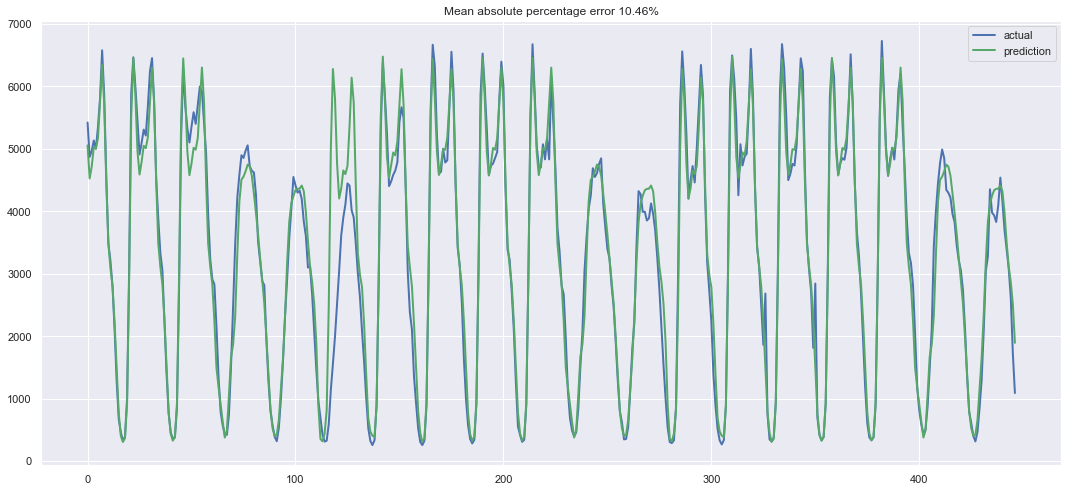

In [112]:
# линейная регрессия
df_forecast = build_forecast_df(series_train, feat_cols, forecast_start_X, forecast_horizon=len(series_test))
df_forecasted = recursive_predict(lr, df_forecast)

plotRecursivePrediction(series_test.x, df_forecasted.x)

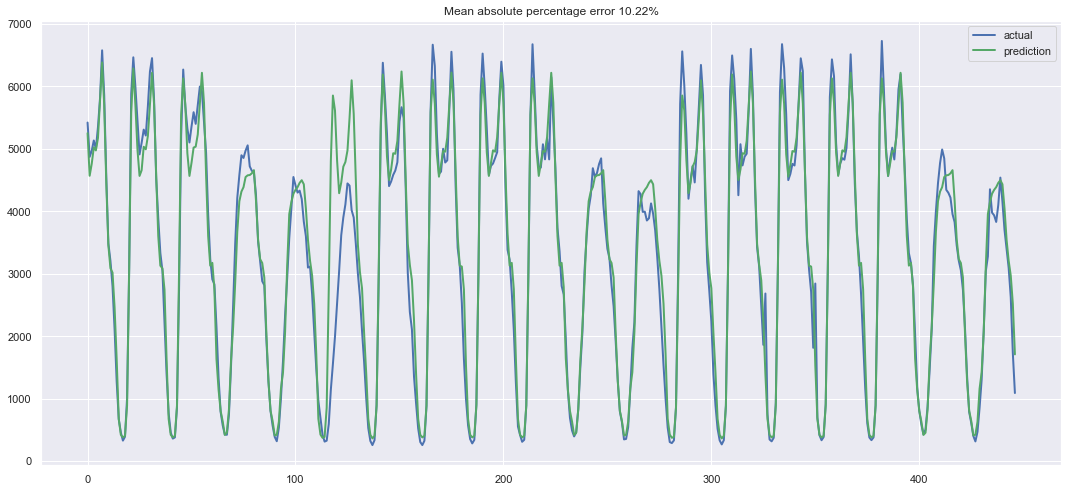

In [113]:
# градиентный бустинг
gb = GradientBoostingRegressor()
result=gb.fit(X_train, y_train)

df_forecast = build_forecast_df(series_train, feat_cols, forecast_start_X, forecast_horizon=len(series_test))
df_forecasted = recursive_predict(gb, df_forecast)

plotRecursivePrediction(series_test.x, df_forecasted.x)

In [143]:
def get_train_forecast_errors(model, X_train, y_train):
    forecast = model.predict(X_train)
    errors = y_train - forecast
    return errors

def plotErrorDistribution(errors):
    #errors = get_train_forecast_errors(gb, X_train, y_train)
    plt.figure(figsize=(10,6))
    plt.hist(errors, density=True, bins=50)
    plt.show()

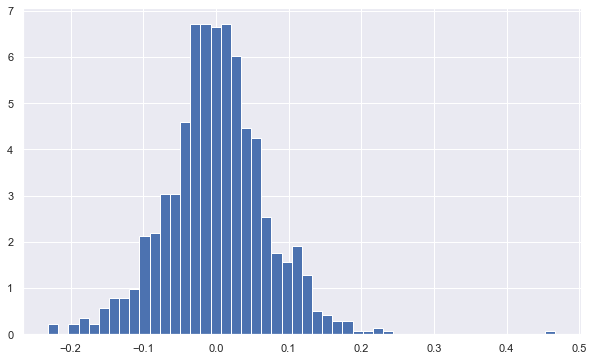

In [144]:
errors = get_train_forecast_errors(gb, X_train, y_train)

plotErrorDistribution(errors)

In [145]:
def recursive_predict_with_noise(model, df_forecast, noise_std=None):
    horizon = len(df_forecast)
    df_pred = df_forecast.copy()
    forecast = []
    lagcols = lag_encoder.lag_columns
    t = df_forecast.index
    
    feat_cols = df_forecast.columns.tolist()
    feat_cols.remove("x")
    
    for i in range(horizon):
        timestamp = t[i]
        features = df_pred.loc[[timestamp], feat_cols]
        next_x = model.predict(features)[0]
        if noise_std is not None:
            next_x = next_x + np.random.normal(0, noise_std)
        if i < horizon-1:
            next_timestamp = t[i+1]
            df_pred.loc[next_timestamp, lagcols[0]] = next_x
            df_pred.loc[next_timestamp, lagcols[1:]] = df_pred.loc[timestamp, lagcols[:-1]].values
        forecast.append(next_x)
    
    df_pred.loc[:, "x"] = forecast
    df_pred.loc[:,:] = scaler.inverse_transform(df_pred)
    return df_pred

def sample_bootstrap_forecasts(model, df_forecast, n_samples=100, noise_std=None):    
    df_conf_int = pd.DataFrame(index=df_forecast.index)
    
    for s in tqdm_notebook(range(n_samples)):
        df_forecasted = recursive_predict_with_noise(model, df_forecast, noise_std=noise_std)
        df_conf_int["forcast_{}".format(s)] = df_forecasted.x.values
    
    return df_conf_int

In [146]:
def plot_samples(df_forc_sample):
    plt.figure(figsize=(14,8))
    for c in df_forc_sample.columns:
        plt.plot(df_forc_sample[c])
    plt.show()

def plotRecursivePredictionConfInterval(y_test, y_forecast, error_std):
    plt.figure(figsize=(15, 7))
    
    error = mean_absolute_percentage_error(y_forecast.values, y_test.values)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    plt.plot(y_forecast.values, "g", label="prediction", linewidth=2.0)
    
    scale = 1.96
    lower = y_forecast - scale * error_std
    upper = y_forecast + scale * error_std

    plt.plot(lower.values, "r--", label="upper bond / lower bond", alpha=0.5)
    plt.plot(upper.values, "r--", alpha=0.5)
    
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)

In [147]:
# градиентный бустинг
df_forc_sample = sample_bootstrap_forecasts(gb, df_forecast, n_samples=100, noise_std=errors.std())

df_forc_sample.head(3)

C:\Users\zhuko\AppData\Local\Temp/ipykernel_13236/351287820.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for s in tqdm_notebook(range(n_samples)):


  0%|          | 0/100 [00:00<?, ?it/s]

,forcast_0,forcast_1,forcast_2,forcast_3,forcast_4,forcast_5,forcast_6,forcast_7,forcast_8,forcast_9,...,forcast_90,forcast_91,forcast_92,forcast_93,forcast_94,forcast_95,forcast_96,forcast_97,forcast_98,forcast_99
2018-08-29 09:00:00,5300.530788,5441.504475,5282.082551,5348.782714,5278.777285,5111.185105,5247.051463,5277.520173,5394.147755,5300.161273,...,5445.269277,5467.537184,5056.019304,5084.740368,5266.040077,5285.195159,5333.760683,5278.233685,5414.460330,5089.169624
2018-08-29 10:00:00,4681.934584,4439.438691,4465.533928,4711.134204,4603.588691,4409.675065,4397.346809,4237.738569,4484.408504,4528.296014,...,4618.188599,4751.467321,4675.043282,4559.104792,4672.199151,4719.581450,4533.968937,4298.559576,4591.819599,4682.051283
2018-08-29 11:00:00,4878.341984,4765.428120,4559.250570,4687.168977,5026.318621,4637.682142,4848.695891,4639.397360,4607.372512,4564.171551,...,4811.789183,4683.185810,4838.792203,4921.678416,4737.194676,4655.465018,4628.347979,4713.263161,4500.788265,4894.579294


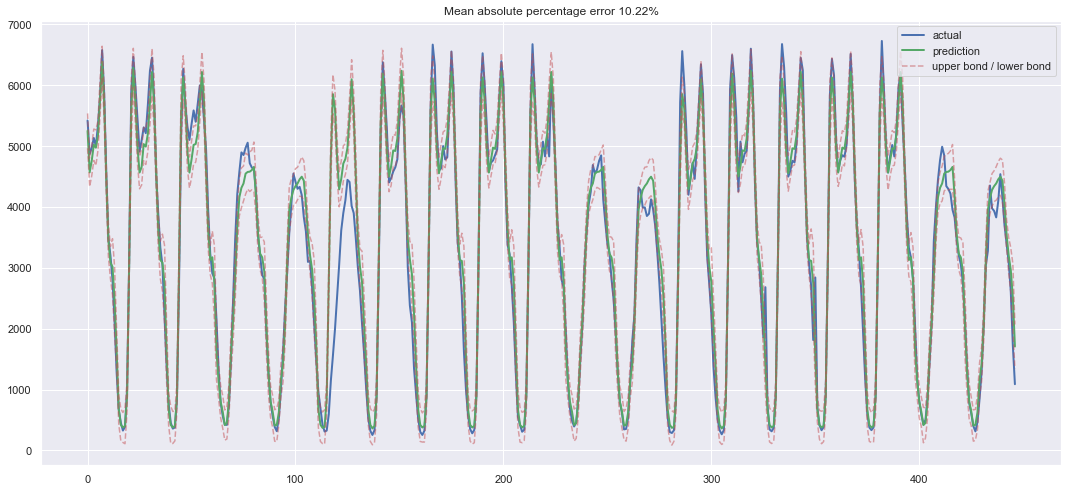

In [155]:
plotRecursivePredictionConfInterval(series_test.x, df_forecasted.x, error_std)

Выводы: использование классических ML методов для прогнозирования временного ряда (линейная регрессия и градиентный бустинг) без дополнительных фичей могут использоваться в качестве baseline решения. Извлечение дополнительных фичей из временного ряда позволяет существенно повысить точность традиционных методов, она становится сравнимой или даже выше точности специальных моделей, таких как SARIMA в нашем случае. 